# House Price Prediction 

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

In [291]:
# load train and test data
train = pd.read_csv("./house-prices-advanced-regression-techniques/train.csv")
test = pd.read_csv("./house-prices-advanced-regression-techniques/test.csv")

In [81]:
# take a look at dataset structure
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [82]:
print(train.shape)

(1460, 81)


In [246]:
test.shape

(1459, 80)

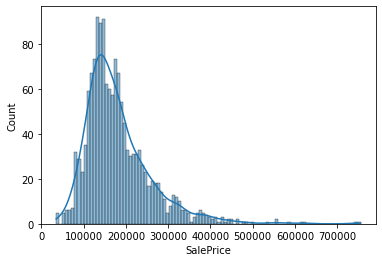

In [111]:
sns.histplot(train['SalePrice'],bins=100,kde=True);

In [16]:
print("Skewness: %f" % train['SalePrice'].skew())
print("Kurtosis: %f" % train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


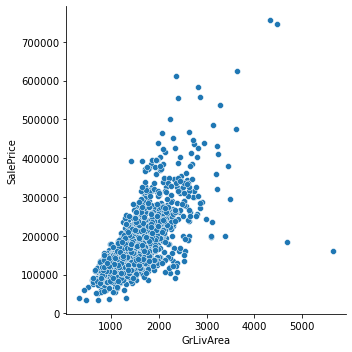

In [23]:
sns.relplot(x="GrLivArea", y="SalePrice", data=train);

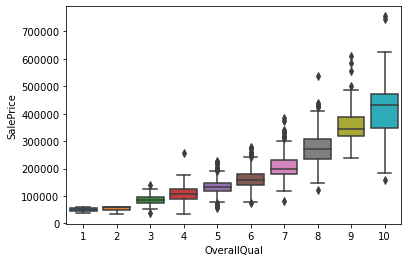

In [28]:
sns.boxplot(x="OverallQual", y="SalePrice", data=train);

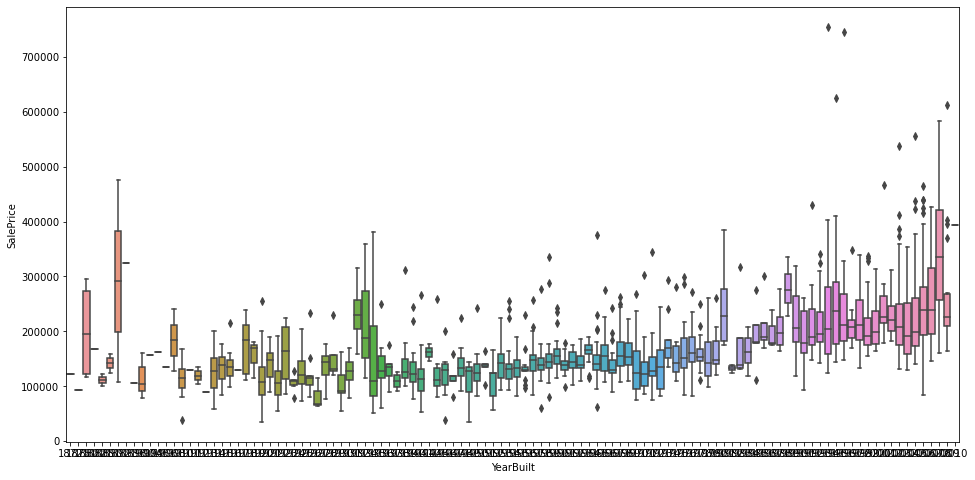

In [35]:
f, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(x="YearBuilt", y="SalePrice", data=train);

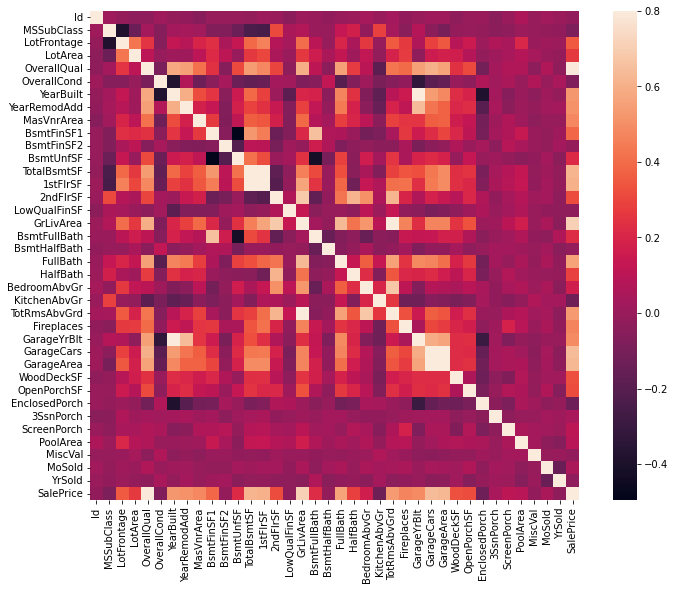

In [36]:

f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);


#### Delete missing data if missing proporation exceeds 15%

In [300]:
# missing data
total = train.isnull().sum().sort_values(ascending=False)
percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)



,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [301]:
#dealing with missing data 
# drop columns
columns_dropped = missing_data[missing_data['Total'] > 1]
df_train = train.drop(columns=(columns_dropped).index)
df_train = df_train.drop(index=train.loc[train['Electrical'].isnull()].index)
df_train.isnull().sum().max() #just checking that there's no missing data missing...
df_train = df_train.iloc[: ,1:]



In [367]:
df_test = test.drop(columns=(columns_dropped).index)
df_test = df_test.iloc[: ,1:]

In [368]:
df_test.shape

(1459, 61)

### Convert categorial data to integer

In [303]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OrdinalEncoder

In [381]:
# covert categorial to integer
categorical_columns_index = [x for x in df_train.columns if df_train[x].dtype == 'object']
oe = OrdinalEncoder()
df_train[categorical_columns_index] = oe.fit_transform(df_train[categorical_columns_index])

In [382]:
df_test = df_test.dropna(axis=0)

In [383]:
# convert test categorial data to integer
df_test[categorical_columns_index] = oe.fit_transform(df_test[categorical_columns_index])

### Tuning by GridSearchCV

In [277]:
from sklearn.model_selection import GridSearchCV
# train the model
SEED = 2021
random_forest_tuning = RandomForestRegressor(random_state = SEED)
param_grid = {
    'n_estimators': [500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' : ['mse'],
    'min_samples_leaf': [5,10,20]}

GSCV = GridSearchCV(estimator=random_forest_tuning, param_grid=param_grid, cv=5)
GSCV.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])
GSCV.best_params_ 


{'criterion': 'mse',
 'max_depth': 8,
 'max_features': 'auto',
 'min_samples_leaf': 5,
 'n_estimators': 500}

In [396]:
df_test.shape

(1447, 61)

### Test

In [400]:
from sklearn.metrics import mean_absolute_error
random_forest_test = RandomForestRegressor(n_estimators=500,
                                           random_state=SEED, 
                                           criterion='mse', 
                                           max_features='auto',
                                           max_depth=8,                                       
                                           min_samples_leaf=5,)
random_forest_test.fit(df_train.iloc[:,:-1], df_train.iloc[:,-1])
y_pred = random_forest_test.predict(df_test)
y_pred

array([127539.91622942, 154253.47911707, 177442.26364954, ...,
       157680.13338885, 117275.52790073, 224609.07164633])

,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,2.0,11622,1.0,3.0,3.0,0.0,4.0,0.0,12.0,...,0,0,0,120,0,0,6,2010,8.0,4.0
1,20,3.0,14267,1.0,0.0,3.0,0.0,0.0,0.0,12.0,...,36,0,0,0,0,12500,6,2010,8.0,4.0
2,60,3.0,13830,1.0,0.0,3.0,0.0,4.0,0.0,8.0,...,34,0,0,0,0,0,3,2010,8.0,4.0
3,60,3.0,9978,1.0,0.0,3.0,0.0,4.0,0.0,8.0,...,36,0,0,0,0,0,6,2010,8.0,4.0
4,120,3.0,5005,1.0,0.0,1.0,0.0,4.0,0.0,22.0,...,82,0,0,144,0,0,1,2010,8.0,4.0


In [401]:
sample_submission = pd.read_csv("./house-prices-advanced-regression-techniques/sample_submission.csv")

In [405]:
sample_submission.head()

,Id,SalePrice
0,1461,169277.052498
1,1462,187758.393989
2,1463,183583.683570
3,1464,179317.477511
4,1465,150730.079977
